# Hamiltonian and eigenvalues, pulses

In this cell the Hamiltonian $H_0=2\pi \left[D\cdot S_z^2 + g_e\cdot B_z \cdot S_z\right]$ is defined.

All mentioned values are constant. The system is initialized to $|\psi_0\rangle$, which corresponds to the eigenvalue of the Hamiltonian with eigenenergy zero.

Eigenfrequencies of the time independent Hamiltonian are printed to console.

A time vector of 1000 points is defined to go from $0$ to $\frac{100}{\omega_{res}}$, where $\omega_{res}$ is one of the two resonant frequencies, arbitrarily choose to investigate the lower one for this cell.

We now let the system evolve under the time dependent Hamiltonian including pulsing of the operator $S_x$ ($S_y$ sorts the same effect), with time dependent amplitude given by a sinusoidal function $amp\cdot \sin{\omega t}$, and investigate how the expectation value of the states evolves, as well as that of the spin operators.

Eigenfrequencies = [0.     2.3094 3.4306] GHz
Expected resonant freuqencies: D +- g_e * B = (3.4306, 2.3094) GHz
Use 2.3094 GHz


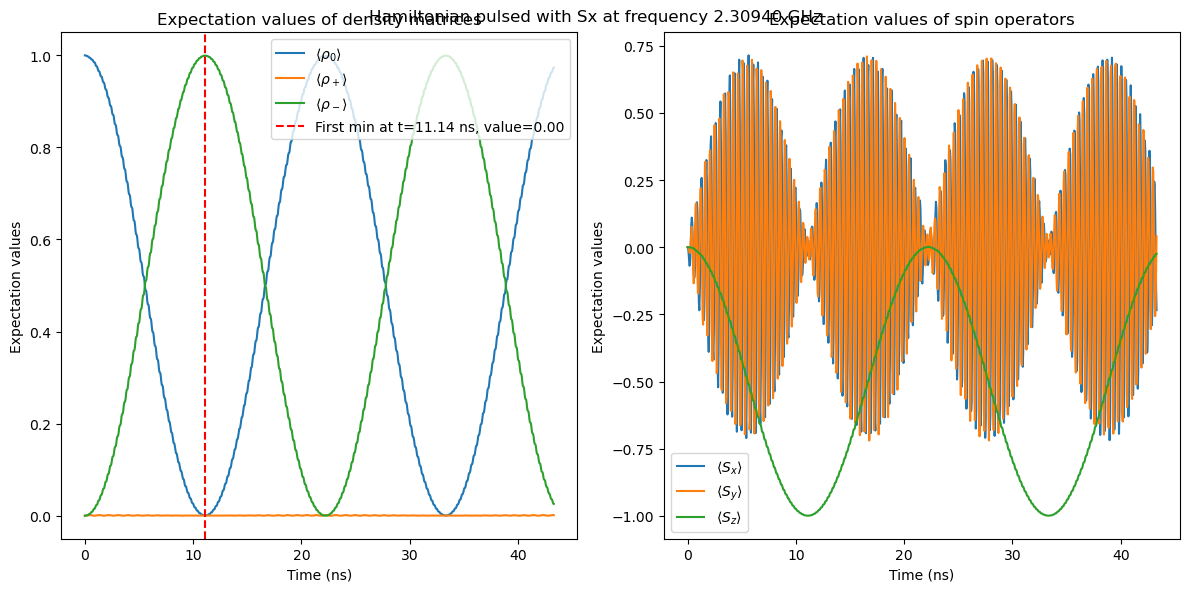

In [69]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

# Hamiltonian for a single NV center (3-level system)
D = 2.87  # Zero-field splitting in GHz
B = 0.02  # Magnetic field in Tesla
g_e = 28.03  # Gyromagnetic ratio of the electron, units are GHz/T
_2PI = 2 * np.pi

# Define the electron spin (S=1) operators
Sz = qt.jmat(1, 'z')  # Sz operator
Sx = qt.jmat(1, 'x')
Sy = qt.jmat(1, 'y')

def pulse(t, args):
    return args['amp'] * np.sin(args['w'] * t)

H0 = (D * (Sz**2) + g_e * B * Sz) * _2PI # Units of energy
eigenfrequencies = H0.eigenenergies() / _2PI # Units of frequency (GHz)
print(f'Eigenfrequencies = {eigenfrequencies} GHz') 
print(f'Expected resonant freuqencies: D +- g_e * B = {(D + g_e * B), (D - g_e * B)} GHz') 
w01 = (D - g_e * B) * _2PI  # Units of Energy
print(f'Use {w01 / _2PI} GHz')   # Units of frequency (GHz)
# Time evolution of states using mesolve
times = np.linspace(0, 100*_2PI/w01, 1000)  # Time array
initial_state = qt.basis(3, 1)  # Initial state

def evolve_and_plot(pulse_arguments, filename):
    # Solve the Schrodinger equation
    result = qt.mesolve([H0, [Sx, pulse]], initial_state, times, args=pulse_arguments)

    state_zero = qt.basis(3, 1)
    rho_zero = state_zero * state_zero.dag()
    state_plus = qt.basis(3, 0)
    rho_plus = state_plus * state_plus.dag()
    state_minus = qt.basis(3, 2)
    rho_minus = state_minus * state_minus.dag()

    # Calculate the expectation values
    expect_rho_zero = qt.expect(rho_zero, result.states)
    expect_rho_plus = qt.expect(rho_plus, result.states)
    expect_rho_minus = qt.expect(rho_minus, result.states)

    expect_sigma_x = qt.expect(Sx, result.states)
    expect_sigma_y = qt.expect(Sy, result.states)
    expect_sigma_z = qt.expect(Sz, result.states)

    # Find the first minimum of expect_rho_zero
    first_min_index = np.argmin(expect_rho_zero[0:500])
    first_min_time = times[first_min_index]
    first_min_value = expect_rho_zero[first_min_index]

    # Plot the results
    plt.figure(figsize=(12, 6))

    # Plot the expectation values of the density matrices
    plt.subplot(1, 2, 1)
    plt.plot(times, expect_rho_zero, label=r'$\langle \rho_0 \rangle$')
    plt.plot(times, expect_rho_plus, label=r'$\langle \rho_+ \rangle$')
    plt.plot(times, expect_rho_minus, label=r'$\langle \rho_- \rangle$')
    #plt.plot(times, pulse(times, args=pulse_arguments), label='Intensity of applied operator', color='grey')
    plt.xlabel('Time (ns)')
    plt.ylabel('Expectation values')
    plt.axvline(x=first_min_time, color='r', linestyle='--', label=f'First min at t={first_min_time:.2f} ns, value={first_min_value:.2f}')
    plt.title('Expectation values of density matrices')
    plt.legend(loc='upper right')

    # Plot the expectation values of the spin operators
    plt.subplot(1, 2, 2)
    plt.plot(times, expect_sigma_x, label=r'$\langle S_x \rangle$')
    plt.plot(times, expect_sigma_y, label=r'$\langle S_y \rangle$')
    plt.plot(times, expect_sigma_z, label=r'$\langle S_z \rangle$')
    plt.xlabel('Time (ns)')
    plt.ylabel('Expectation values')
    plt.title('Expectation values of spin operators')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'plots/{filename}.png')

    plt.suptitle(f'Hamiltonian pulsed with Sx at frequency {pulse_arguments["w"] / _2PI:.5f} GHz')
    plt.show()


pulse_arguments = {
    'w': w01*1.00, 
    'amp': 0.4
}

evolve_and_plot(pulse_arguments, "sim_oscillation_at_resonance.png")

In [ ]:
H0.eigenstates()

(array([ 0.        , 14.51038815, 21.55509551]),
 array([Quantum object: dims=[[3], [1]], shape=(3, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.]
         [1.]
         [0.]]                                                                ,
        Quantum object: dims=[[3], [1]], shape=(3, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.]
         [0.]
         [1.]]                                                                ,
        Quantum object: dims=[[3], [1]], shape=(3, 1), type='ket', dtype=Dense
        Qobj data =
        [[1.]
         [0.]
         [0.]]                                                                ],
       dtype=object))

We see that by applying $S_x$ modulated by a sinusoidal wave at the resonant frequency corresponding to the transition $|\psi_0\rangle \leftrightarrow |\psi_{-1}\rangle$, we are able to periodically, and most importantly entirely, invert the spin population. Let's now take a look at the next transition $|\psi_0\rangle \leftrightarrow |\psi_{+1}\rangle$, by pulsing $S_x$ with a sinusoidal wave with the other resonant frequency, corresponding to the other non-zero eigenfrequency of the Hamiltonian, $D-B\cdot g_e$, keep in mind $g_e$ is negative.

This oscillatory behaviour in spin populations takes the name of Rabi oscillations. The Rabi frequency is the frequency of the observed oscillation. This is useful because it allows us to determine the pulse time such that the population is maximally inverted ($\pi$ pulse), as well as the time to have the system in an exact superposition state ($\pi/2$ pulse)

In the plot we see marked in red the time it takes for spin populations to be maximally inverted. This is the duration of a $\pi$ pulse for the relative transition.

Observe that the probability is now being periodically exchanged by $|\psi_0\rangle \leftrightarrow |\psi_{+1}\rangle$ as expected.

Use 2.3094 GHz


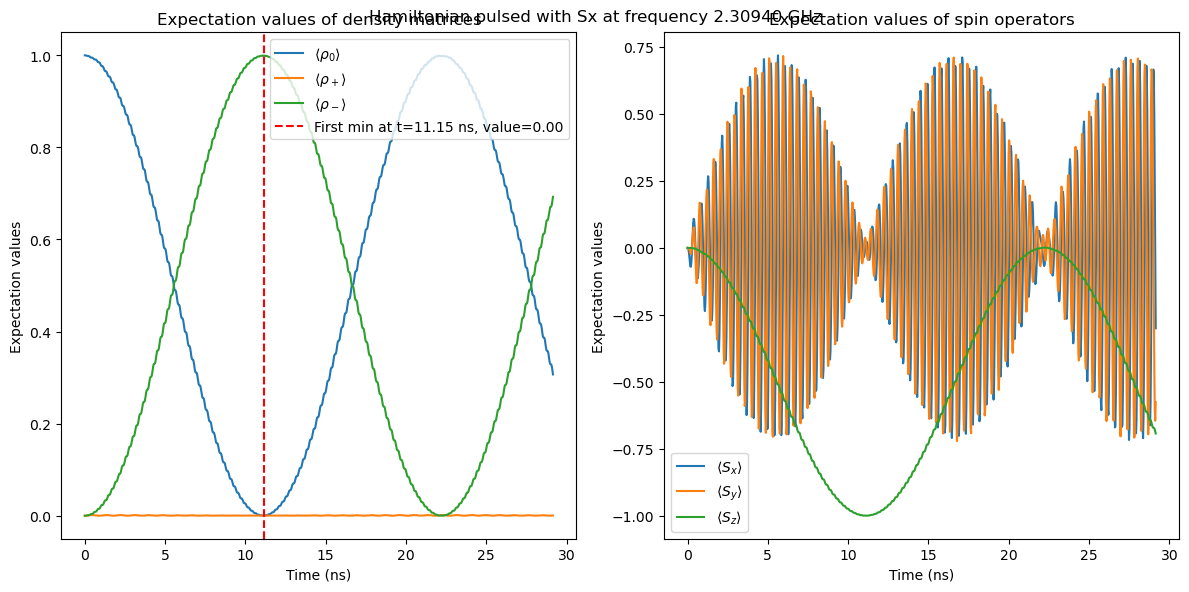

In [ ]:
w01 = (D - g_e * B) * _2PI  # Units of Energy
print(f'Use {w01 / _2PI} GHz')   # Units of frequency (GHz)

pulse_arguments = {
    'w': w01*1.00, 
    'amp': 0.4
}

evolve_and_plot(pulse_arguments)

# Off-resonant pulsing

Consider now the frequencies immediately around the lower resonant one, and observe what happens to the state probabilities as a function of time.
For example apply frequencies $[0.99, 1.01, 1.02]$ times the resonant frequency.

Use 2.3094 GHz


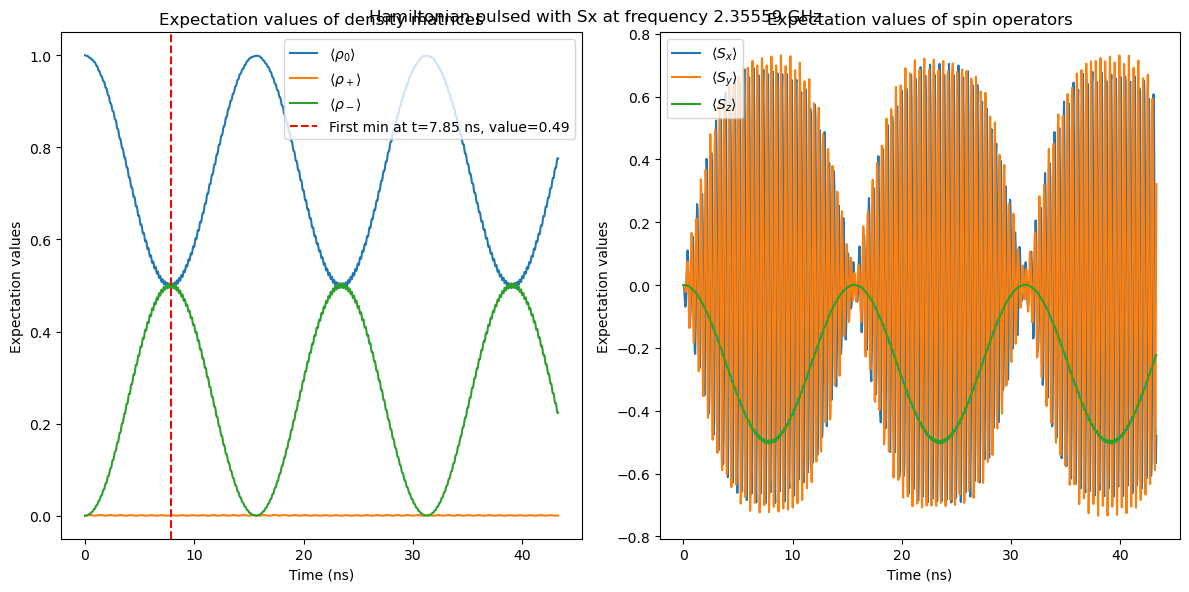

In [72]:
w01 = (D - g_e * B) * _2PI  # Units of Energy
print(f'Use {w01 / _2PI} GHz')   # Units of frequency (GHz)

pulse_arguments = {
    'w': w01*1.02, 
    'amp': 0.4
}
evolve_and_plot(pulse_arguments, "sim_oscillation_off_102")
# pulse_arguments = {
#     'w': w01*1.01, 
#     'amp': 0.4
# }
# evolve_and_plot(pulse_arguments)
# pulse_arguments = {
#     'w': w01*1.02, 
#     'amp': 0.4
# }
# evolve_and_plot(pulse_arguments)

Most importantly we observe how the pulse time to achieve maximal states changes by shifting from the resonant frequency(ies), in other words a decrease in the Rabi period.

Another key takeaway is the lower efficiency in the inversion of the populations. In this example by ofsetting the frequency by 2% the excitation efficiency drops to 49%.

# Fix pulse length, explore frequency space

Now observe what happens to the expectation value of $|\psi_0 \rangle\langle \psi_0|$ as we pulse the system with frequency in a linear space centered around the (zero field) resonant frequency $D$. Pulse length is arbitrarily taken to be the average of the $\pi$ pulses for the two resonant frequencies, $11.12$ ns. The linspace of observed frequencies is chosen to go from $D+2\cdot g_e\cdot B$ to $D-2\cdot g_e\cdot B$ for a total of 100 frequencies.

Use the expectation value calculator from qutip to find the expectation value of $|\psi_0 \rangle$ after the pulse.

This plot closely resembles a ODMR, Optically Detected Magnetic Resonance. In the case of NV centers in diamonds, an optical excitation of an NV with $m_s=\pm 1$ has a higher probability of relaxing to ground state in way that doesn't involve the emission of a photon in the range of the energy gap (because of Inter System Crossing) compared to NVs with $m_s=0$. This translates to the fluorescence manifesting a 'dip' in correlation to spins not being in the initial state.

The main reason why a lab-based ODMR spectrum has a much lower contrast compared to this simulation is that even for NVs with $m_s\neq 0$ the fluorescence is not zero. The resonant frequencies (dip positions) are however the same.

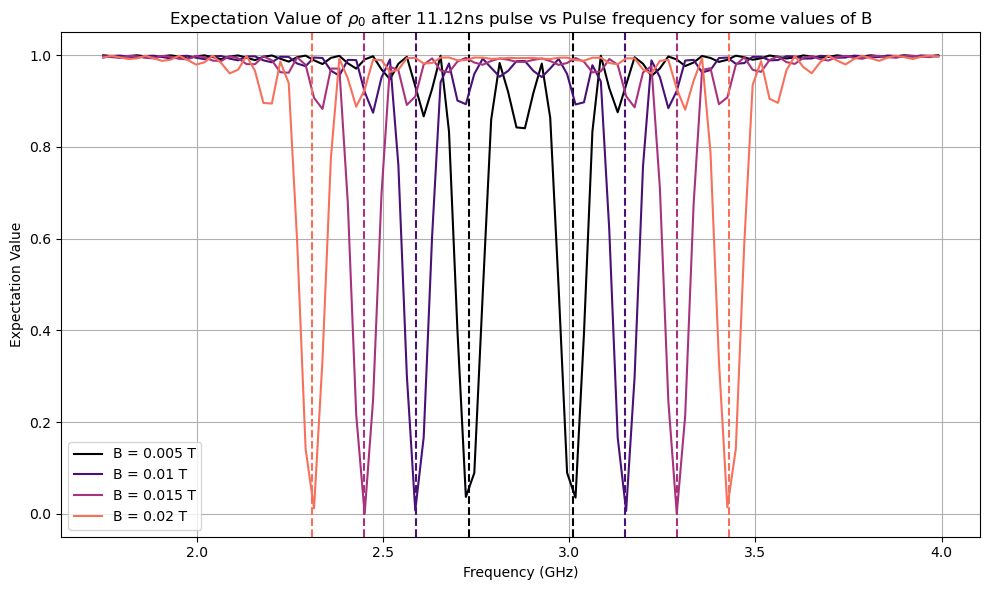

In [ ]:
# Define the list of B values
B_values = [0.005, 0.01, 0.015, 0.02]

# Define the frequency space based on current B
frequency_space = np.linspace(D + 2 * g_e * B_values[-1], D - 2 * g_e * B_values[-1], 100)

# Define the new times array to end at the pi pulse value
times = np.linspace(0, 11.14, 100)

state_zero = qt.basis(3, 1)
rho_zero = state_zero * state_zero.dag()

# Plotting setup
plt.figure(figsize=(10, 6))
colors = plt.cm.magma(np.linspace(0, 0.7, len(B_values)))

for i, B in enumerate(B_values):
    # Recompute the Hamiltonian
    H0 = (D * Sz**2 + g_e * B * Sz) * _2PI  # Units of energy
    eigenfrequencies = H0.eigenenergies() / _2PI  # Units of frequency (GHz)
    
    expectation_values = []

    for frequency in frequency_space:
        pulse_arguments = {
            'w': frequency * _2PI,
            'amp': 0.4
        }
        results = qt.mesolve([H0, [qt.jmat(1, 'x'), lambda t, args: args['amp'] * np.cos(args['w'] * t)]], state_zero, times, args=pulse_arguments)
        expected_value_initial_state = qt.expect(rho_zero, results.states[-1])
        expectation_values.append(expected_value_initial_state)
    
    # Plot the expectation values vs frequency space for current B
    plt.plot(frequency_space, expectation_values, color=colors[i], label=f'B = {B} T')
    
    # Add vertical lines for eigenfrequencies
    for ef in eigenfrequencies:
        if ef != 0:
            plt.axvline(x=ef, color=colors[i], linestyle='--')

# Add labels, titles, and legend
plt.xlabel('Frequency (GHz)')
plt.ylabel('Expectation Value')

plt.legend()
plt.grid(True)
plt.savefig('plots/sim_odmr_aligned.png')

# Adjust layout and show the plot
plt.title('Expectation Value of $\\rho_0$ after 11.12ns pulse vs Pulse frequency for some values of B')
plt.tight_layout()
plt.show()

# Angle dependence of ODMR spectrum

So far it was assumed that only the z component of the spin $S_z$ could couple to the magnetic field, also taken to be along the $\hat{z}$ direction. Releasing this assumption changes the hamiltonian term $B_zS_z$ into $B_zS_z + B_xS_x + B_yS_y$ for arbitrarily oriented magnetic field.

Now define the applied constant magnetic field as $\vec{B}$ in spherical coordinates, where $B$=B is the magnitude, $\theta$=polar is the polar angle (angle wrt the $\hat{z}$ axis), and $\phi$=azimuthal is the angle of the projection onto the $\hat{x}-\hat{y}$ plane.

Let's first look at what happens by changing the Hamiltonian, but keeping $\vec B$ aligned to the $\hat{z}$ axis

In [ ]:
B = 0.02    # magnetic field in Tesla
polar = 5   # angle in degrees
azimuthal = 0   # angle in degrees

def polar_to_cartesian(r, theta, phi):
    z = r * np.cos(np.radians(theta))
    x = r * np.sin(np.radians(theta)) * np.cos(np.radians(phi))
    y = r * np.sin(np.radians(theta)) * np.sin(np.radians(phi))
    return x, y, z

Bx, By, Bz = polar_to_cartesian(B, polar, azimuthal)

H0 = (D * (Sz**2) + g_e * (Bz * Sz + Bx * Sx + By * Sy)) * _2PI # Units of energy
eigenfrequencies = H0.eigenenergies() / _2PI # Units of frequency (GHz)
print(f'Eigenfrequencies = {eigenfrequencies} GHz') 
print(f'Frequency zero to minus one: {eigenfrequencies[1] - eigenfrequencies[0]:.4f}GHz, zero to plus one: {eigenfrequencies[2] - eigenfrequencies[0]:.4f}GHz')

Eigenfrequencies = [-8.64249156e-04  2.31204928e+00  3.42881497e+00] GHz
Frequency zero to minus one: 2.3129GHz, zero to plus one: 3.4297GHz


The eigenenergies (and the related frequencies) are clearly the same as studied so far.

Things get interesting when we introduce a non-zero polar angle, in particular we observe the gaps between eigenfrequencies lose their symmetry around $D$, as can be seen from the printed parameters.

Now define a function that constructs the time independent Hamiltonian, define also a function that computes the ratio of the distances of the two resonant frequencies from $D$, this is a measure of the 'asymmetry' of the splitting.

This 'asymmetry' is plotted for misalignment angles between 0 and 360 degrees. An interesting observation is that the 

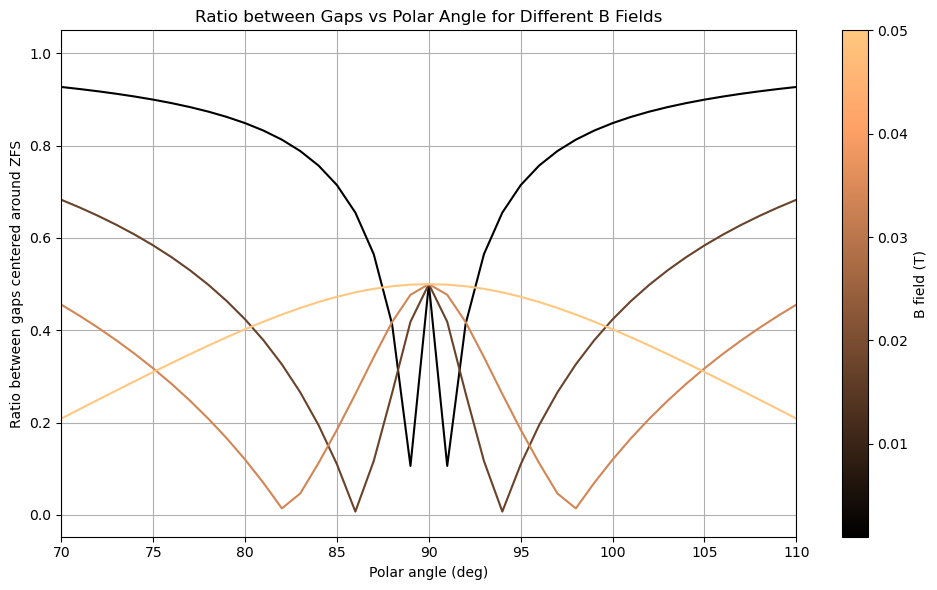

In [ ]:
def hamiltonian_given_B(D, g_e, B, polar, azimuthal):
    """
    Construct the Hamiltonian for given magnetic field parameters.

    Parameters:
    - D (float): Zero-field splitting in GHz.
    - g_e (float): Gyromagnetic ratio of the electron in GHz/T.
    - B (float): Magnetic field magnitude in Tesla.
    - polar (float): Polar angle in degrees.
    - azimuthal (float): Azimuthal angle in degrees.

    Returns:
    - H0 (Qobj): Hamiltonian.
    """
    Bx, By, Bz = polar_to_cartesian(B, polar, azimuthal)

    if not B == 0:
        # Sanity check to ensure the magnetic field is correctly calculated
        assert np.abs(Bx**2 + By**2 + Bz**2 - B**2) <= B / 1000

    H0 = D * Sz**2 + g_e * (Bz * Sz + Bx * Sx + By * Sy)
    return H0

def split_ratio_given_angles(D, g_e, B, polar, azimuthal):
    """
    Calculate the split ratio given the angles.

    Parameters:
    - D (float): Zero-field splitting in GHz.
    - g_e (float): Gyromagnetic ratio of the electron in GHz/T.
    - B (float): Magnetic field magnitude in Tesla.
    - polar (float): Polar angle in degrees.
    - azimuthal (float): Azimuthal angle in degrees.

    Returns:
    - split_ratio (float): Split ratio.
    """
    H0 = hamiltonian_given_B(D, g_e, B, polar, azimuthal)
    eigenenergies, _ = H0.eigenstates()
    fa = eigenenergies[1] - eigenenergies[0]
    fb = eigenenergies[2] - eigenenergies[0]

    return abs((D - fa) / (D - fb))


# Define the values of B
B_values = [0.001, 0.005, 0.01, 0.05]

# Define the range of angles
angles = np.linspace(0, 360, 361)

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.copper(np.linspace(0, 1, len(B_values)))  # Use a colormap for color gradient

# Calculate and plot the ratios for each B value
for i, B in enumerate(B_values):
    ratios = [split_ratio_given_angles(D, g_e, B, polar, 0) for polar in angles]
    ax.plot(angles, ratios, color=colors[i], label=f'B = {B} T')

# Add labels, grid, and legend
ax.set_xlabel('Polar angle (deg)')
ax.set_ylabel('Ratio between gaps centered around ZFS')
ax.set_title('Ratio between Gaps vs Polar Angle for Different B Fields')
ax.grid(True)

# Add colorbar to indicate B values
sm = plt.cm.ScalarMappable(cmap='copper', norm=plt.Normalize(vmin=min(B_values), vmax=max(B_values)))
sm.set_array([])  # Dummy data for the color bar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('B field (T)')

# Adjust layout and show the plot
plt.tight_layout()
plt.xlim(70,110)
plt.show()